In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
from collections import Counter

import numpy as np

import torch
import torch.optim as optim

from torchvision import transforms

from models import *

from preprocessing import AdjustContrast, generate_dataloader, get_labels_mapping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

c:\Users\flori\anaconda3\envs\cv_skin_cancer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET = "marmal88/skin_cancer"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


## Import and preprocess data

In [4]:
le = LabelEncoder()

# Basic transformations for all images
preprocess_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

# Data augmentation techniques for minority classes
# see more in preprocessing.py
train_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomCrop(size=(224, 224)),
        AdjustContrast(contrast_factor=0.95),
        AdjustContrast(contrast_factor=1.05)
    ])
])

# Center crop for validation and test set
val_test_transform = transforms.Compose([
    transforms.CenterCrop(size=(224, 224))
])

In [5]:
# Create training dataloader
train_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='train',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=train_transform,
    train=True,
    batch_size=64,
    shuffle=True
)

# Create validation dataloader
valid_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='validation',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=val_test_transform,
    train=False,
    batch_size=64,
    shuffle=True
)

# Create testing dataloader
test_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='test',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=val_test_transform,
    train=False,
    batch_size=64,
    shuffle=True
)

### Cancer repartition

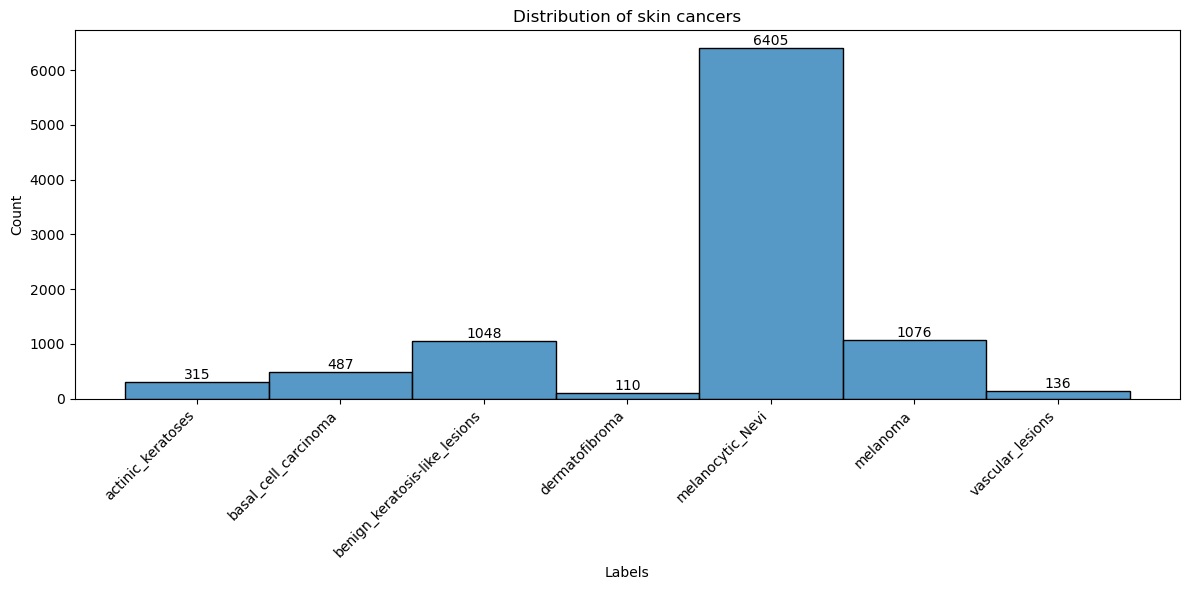

In [7]:
label_mapping = get_labels_mapping(labelencoder=le)
unique_labels = train_dataloader.dataset.tensors[1].tolist()
label_count = [label_mapping[val] for val in unique_labels]
counts = Counter(label_count)

plt.figure(figsize=(12, 6))

ax = sns.histplot(label_count, bins=len(set(label_count)), discrete=True)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height,
                f"{int(height)}", ha="center", va="bottom", fontsize=10)

ax.set_title("Distribution of skin cancers")
ax.set_xlabel("Labels")
plt.xticks(rotation=45, ha="right")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Randomly select an image and display it with its associated label.

melanocytic_Nevi


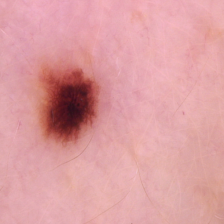

In [8]:
idx = np.random.choice(len(train_dataloader.dataset))
img = transforms.ToPILImage()(train_dataloader.dataset[idx]['image'])
label = label_mapping[train_dataloader.dataset[idx]['label'].item()]
print(label)
display(img)

# Train and evaluate model

In [ ]:
model = ResNet18(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, delta=0)

n_epochs = 50

train_loss_history, train_accuracy_history = [], []
val_loss_history, val_accuracy_history = [], []

for epoch in range(1, n_epochs + 1):
    # Train the model
    epoch_train_loss, epoch_train_accuracy = train_model(
        model=model,
        device=device,
        train_loader=train_dataloader,
        loss_function=criterion,
        optimizer=optimizer,
        epoch=epoch,
        save=True,
        verbose=2
    )
    # Save training metrics
    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    # Validation part
    epoch_val_loss, epoch_val_accuracy = validate_model(
        model=model,
        device=device,
        valid_loader=valid_dataloader,
        loss_function=criterion,
        save=True,
        verbose=True
    )
    # Save validation metrics
    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(epoch_val_accuracy)

    # Check for early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# If early stopping, load best model parameters in current model
early_stopping.load_best_model(model)

Train Epoch 1 [0/9577 (0%)]	Loss: 2.236320
Train Epoch 1 [640/9577 (7%)]	Loss: 1.245491
Train Epoch 1 [1280/9577 (13%)]	Loss: 0.712765
Train Epoch 1 [1920/9577 (20%)]	Loss: 0.883416
Train Epoch 1 [2560/9577 (27%)]	Loss: 1.111355
Train Epoch 1 [3200/9577 (33%)]	Loss: 0.804210
Train Epoch 1 [3840/9577 (40%)]	Loss: 0.805850
Train Epoch 1 [4480/9577 (47%)]	Loss: 0.574771
Train Epoch 1 [5120/9577 (53%)]	Loss: 0.547937
Train Epoch 1 [5760/9577 (60%)]	Loss: 0.721167
Train Epoch 1 [6400/9577 (67%)]	Loss: 0.715141
Train Epoch 1 [7040/9577 (74%)]	Loss: 0.831792
Train Epoch 1 [7680/9577 (80%)]	Loss: 0.750594
Train Epoch 1 [8320/9577 (87%)]	Loss: 0.972479
Train Epoch 1 [8960/9577 (94%)]	Loss: 0.878767

Train set : Average loss 0.8692, Accuracy : 6625/9577 (69%)

Validation set : Average Loss: 0.9524, Accuracy : 1633/2492 (66%)

Train Epoch 2 [0/9577 (0%)]	Loss: 0.615630
Train Epoch 2 [640/9577 (7%)]	Loss: 0.633051
Train Epoch 2 [1280/9577 (13%)]	Loss: 0.748043
Train Epoch 2 [1920/9577 (20%)]	Loss:

## Loss and accuracy plots

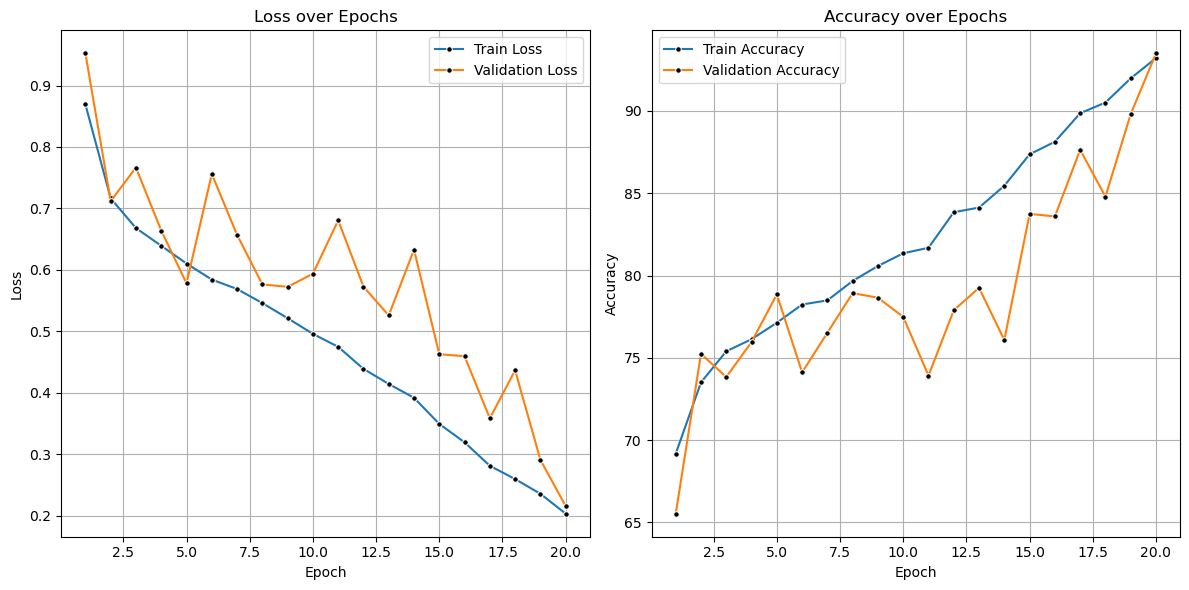

In [55]:
train_loss_history = [float(train_loss_history[i]) for i in range(len(train_loss_history))]
val_loss_history = [float(val_loss_history[i]) for i in range(len(val_loss_history))]

epochs = range(1, n_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss
sns.lineplot(x=epochs, y=train_loss_history, label='Train Loss', marker='o', markersize=4, markerfacecolor='black', ax=axes[0])
sns.lineplot(x=epochs, y=val_loss_history, label='Validation Loss', marker='o', markersize=4, markerfacecolor='black', ax=axes[0])
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
sns.lineplot(x=epochs, y=train_accuracy_history, label='Train Accuracy', marker='o', markersize=4, markerfacecolor='black', ax=axes[1])
sns.lineplot(x=epochs, y=val_accuracy_history, label='Validation Accuracy', marker='o', markersize=4, markerfacecolor='black', ax=axes[1])
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Test model

In [10]:
test_correct = 0
with torch.no_grad():
    for sample in test_dataloader:
        test_data, test_label = sample['image'].to(device), sample['label'].to(device)
        y_pred_test = model(test_data).argmax(dim=1, keepdim=True)
        test_correct += y_pred_test.eq(test_label.to(device).view_as(y_pred_test)).sum().item()

print("Test accuracy : {}/{} ({:.2f}%)".format(
    test_correct, len(test_dataloader.dataset), 
    test_correct / len(test_dataloader.dataset) * 100
))

Test accuracy : 1181/1285 (91.91%)


Predict on a random chosen image from the test dataset and see the predictions with asociated probabilities

Predicted : 4, Actual : 4


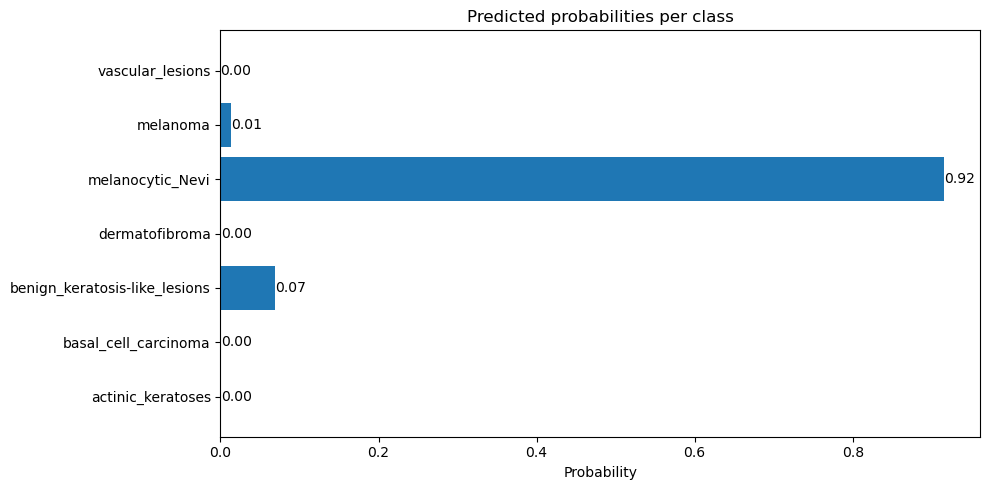

In [62]:
idx = np.random.choice(len(test_dataloader.dataset))
example = test_dataloader.dataset[idx]['image'].unsqueeze(0).to(device)
example_label = test_dataloader.dataset[idx]['label'].unsqueeze(0).to(device)

with torch.no_grad():
    output = model(example)
    print(f"Predicted : {output.argmax(1).item()}, Actual : {example_label.item()}")

probs = nn.functional.softmax(output[0], dim=0).tolist()

fig, ax_h = plt.subplots(figsize=(10, 5))

bars = ax_h.barh(list(label_mapping.values()), probs)

for bar in bars:
    width = bar.get_width()
    ax_h.text(width, bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}", va="center")

ax_h.set_title("Predicted probabilities per class")
ax_h.set_xlabel("Probability")
plt.tight_layout()
plt.show()